In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/NLP/DeepLearningForText&Sequences")
os.getcwd()

'/content/drive/MyDrive/NLP/DeepLearningForText&Sequences'

# **Advanced use of recurrent neural networks**

- We will review three advanced techniques for improving the performance and generalization power of recurrent neural networks.

- We will demonstarte all three concepts on a temperature-forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, ,which we use to predict what the temperature will be 24 hours after the last data points.

- This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

- We will cover the following techniques:
 - **Recurrent dropout**: This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.

 - **Stacking recurrent layers**: This increases the representational power of the network (at the cost of higher computational loads).

 - **Bidirrectional recurrent layers**: These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

## **A temperature-forecasting problem**

- Until now, the only seequence data we have covered has been text data.

- But sequence data is found in many more problems than just language processing.

- In all the examples in this section, we will play with a weather timeseries dataset recorded at the Weather Station at the Max planck Institute for Biogeochemistry in Jena, Germany.

- In this dataset, 14 different quantities (such as temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years.

- The original data goes back to 2003, but this example is limited to data from 2009-2016.

- This dataset is perfect for learning to work with numerical timeseries.

- We will use it to build a model that takes as input some data from the recent past (a few days' worth of data points) and predicts the air temperature 24 hours in the future.

## **Download and uncompress the data**

In [3]:
curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir,"jena_climate")
#os.mkdir(data_dir)
os.chdir(data_dir)
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /content/drive/MyDrive/NLP/DeepLearningForText&Sequences/jena_climate


In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-12-29 16:20:27--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.133.40, 52.217.106.86, 52.217.83.158, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.133.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  37.5MB/s    in 0.3s    

2022-12-29 16:20:28 (37.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [ ]:
!ls

jena_climate_2009_2016.csv.zip


In [ ]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## **Let's look at the data**

In [4]:
# Inspecting the data of the Jena weather dataset
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [5]:
f = open(fname)
data = f.read()
f.close()

In [6]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [7]:
lines[1]

'01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'

In [8]:
print("Headers: \n")
print(header)
print("\n")
print("Number of lines of data: {}".format(len(lines)))

Headers: 

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


Number of lines of data: 420451


- This ouputs a count of 420,551 lines of data.

- Each line is a timestep: a record of a date and 14 weather-related values) as well as the headers.












## **# Now, convert all 420,451 lines of data into a Numpy array.**

In [9]:
# Parsing the data

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

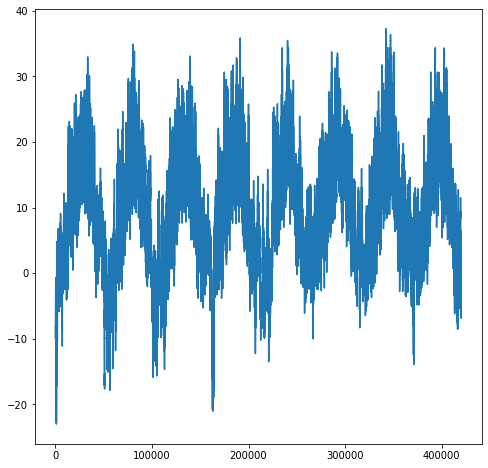

In [ ]:
# Plotting the temperature timeseries

# Here is the plot of temperature (in degrees Celsius) over time.
# On this plot, we can clearly see the yearly periodicity of temperature.

from matplotlib import pyplot as plt
temp = float_data[:, 1]
plt.figure(figsize=(8,8))
plt.plot(range(len(temp)), temp)
plt.show()

- Here is a more narrow plot of the first 10 days of temperature data.

- Because the data is recorded every 10 minutes, we get 144 data points per day.

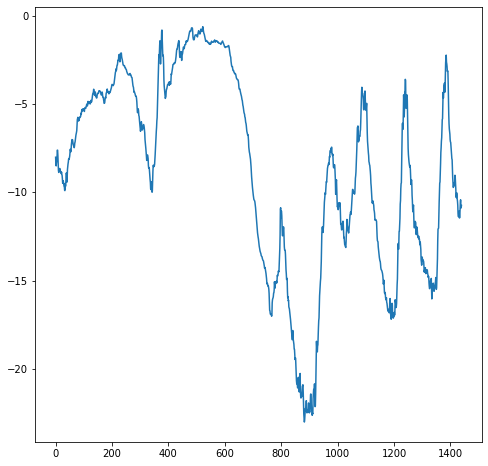

In [ ]:
# Plotting the first 10 days of the temperature timeseries
plt.figure(figsize=(8,8))
plt.plot(range(1440), temp[:1440])
plt.show()

- On this plot, we can see daily periodicity, especially evident for the last 4 days.

- Also note that this 10-day period must be coming from a fairly cold winter month.

- If we were trying to pedict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data.

- But looking at the data over a scale of days, the temperature looks a lot more chaotic.

- Is this timeseries predictable at a daily scale?

## **Preparing the data**

- The exact formulation of the problem will be as follows:
 - Given data going as far back as lookback timesteps (a timestep is 10 minutes)
 - And sampled every steps timesteps, can we predict the temperature in delay timesteps?

- We will use the following parameter values:
 - lookback = 720---Observations will go back 5 days.
 - steps = 6---Observations will be sampled at one data point per hour.
 - delay = 144---Targets will be 24 hours in the future.

- To get started, we need to do two things:
 - Preprocess the data to a format a neural network can ingest.
 - This is easy: the data is already numerical, so we don't need to do any vectorization.
 - But each timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000).
 - We will normalize each timeseries independently so that they all take small values on a similar scale.
 - We will write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future.
 - Because the samples in the dataset are highly redundant (sample N and sample N+1 will have most of their timesteps in common).
 - It would be wasteful to explictitly allocate every sample.
 - Instead, we will generate the samples on the fly using the original data.

 ------------------------------------------------------------------
 - We will preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation.
 - We are going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.

In [ ]:
# Normalizing the data

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
# Generator yielding timeseries samples and their targets

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
          min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

# It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array
# target temperatures

- Now let's use the generator function to instantiate three generators:
 - one for training
 - one for validation
 - and one for testing
- Each will look at different temporal segments of the original data:
 - The training generator looks at the first 200000 timesteps,
 - The validation generator looks at the following 100000,
 - The test generator looks at the remainder.

In [ ]:
# Preparing the training, validation, and test generators

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

val_steps =  (300000 - 200001 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(float_data) - 300001 - lookback) # how many steps to draw from test_gen in order to see the entire test set

### **A common-sense, non-machine-learning baseline**

- Before we start using black-box deep learning models to solve the temperature prediction problem, let's try a simple, common-sense approach.

In [ ]:
# Computing the common-sense baseline MAE

def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
  
evaluate_naive_method()

0.3055509902264915


- This yields an MAE of 0.30
-  Because the temperature data has been normalized to be cntered on 0 and have a standard deviation of 1.

In [ ]:
# Converting the MAE back to a celsius error
celsius_mae = 0.30 * std[1]
celsius_mae

2.6557497246613857

- That's a fairly large average absolute error.
- Now the game is to use our knowledge of deep learning to do better.

### **A basic machine-learning approach**

- In the same way that it's useful to establish a common-sense baseline before trying machine-learning approaches.
- It is useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs.

- This is the best way to make sure any further complexity we throw at the problem is legitimate and delivers real benefits.

In [ ]:
# Training and evaluating a densely connected model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3360)              0         
                                                                 
 dense (Dense)               (None, 32)                107552    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
496/500 [============================>.] - ETA: 0s - loss: 1.2683

KeyboardInterrupt: ignored

In [ ]:
# Plottting results

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

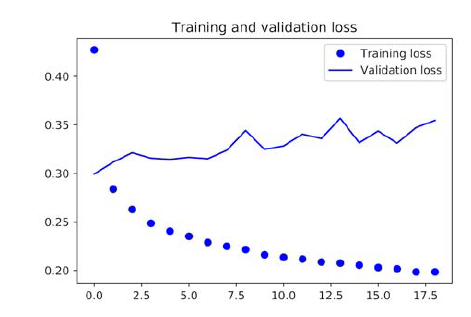

- Some of the validation losses are close to the no-learning baseline, but not reliably.

- This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. 

- Our common sense contains a lot of valuable information that a machine-learning model doesn’t have access to.

- We may wonder, if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model we’re training find it and improve on it? Because this simple solution isn’t what we training setup is looking for. 

- The space of models in which we’re searching for a solution—that is, our
hypothesis space—is the space of all possible two-layer networks with the configuration we defined. 

- These networks are already fairly complicated. When we’re looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it’s technically part of the hypothesis space. 

- That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

### **A first recurrent baseline**

- The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem. 

- The previous approach first flattened the timeseries, which removed the notion of time from the input data. 

- Let’s instead look at the data as what it is: a sequence, where causality and order matter. 

- We’ll try a recurrent-sequence processing model—it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.

- Instead of the LSTM layer introduced in the previous section, we’ll use the GRU layer, developed by Chung et al. in 2014.5 Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as LSTM). 

- This trade-off between computational expensiveness and representational
power is seen everywhere in machine learning.

In [ ]:
# Training and evaluating a GRU-based model

from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSpro
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
# Plottting results

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

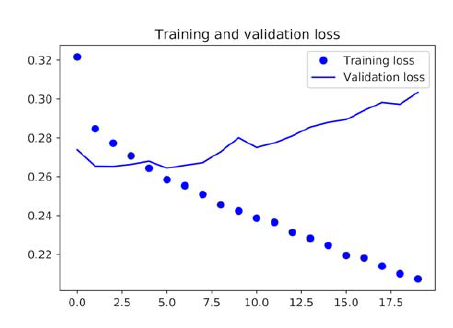

- Above figure shows the results. Much better! we can significantly beat the commonsense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

- The new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35°C after denormalization. 

- That’s a solid gain on the initial error of 2.57°C, but we probably still have a bit of a margin for improvement.

### **Using recurrent dropout to fight overfitting**

- It’s evident from the training and validation curves that the model is overfitting: the training and validation losses start to diverge considerably after a few epochs. 

- We’re already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to.

- But how to correctly apply dropout in recurrent networks isn’t a trivial question. 

- It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. 

- In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning determined the proper way to use dropout with a recurrent network: the same
dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep.

- What’s more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). 

- Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

- Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. 

- Every recurrent layer in Keras has two dropout-related arguments: **dropout**, a float specifying the dropout rate for input units of the layer, and **recurrent_dropout**, specifying the dropout rate of the recurrent units. 

- Let’s add dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting.

- Because networks being regularized with dropout always take longer to fully converge, we’ll train the network for twice as many epochs.

In [ ]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                4608      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

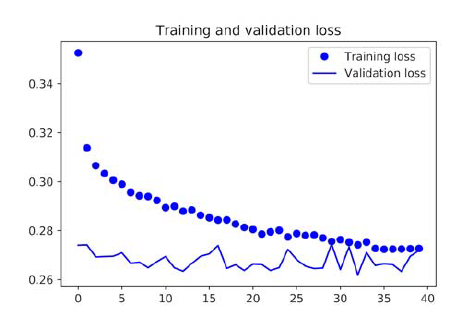

- Above figure shows the results. Success! we’re no longer overfitting during the first 30 epochs. 

- But although we have more stable evaluation scores, our best scores aren’t
much lower than they were previously.

### **Stacking recurrent layers**

- Because we’re no longer overfitting but seem to have hit a performance bottleneck, we should consider increasing the capacity of the network.

- Recall the description of the universal machine-learning workflow: it’s generally a good idea to increase the capacity of our network until overfitting becomes the primary obstacle (assuming we’re already taking basic steps to mitigate overfitting, such as using dropout). 

- As long as we aren’t overfitting too badly, we’re likely under capacity.

- Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. 

- Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, what currently powers the Google Translate algorithm is a stack of seven large LSTM layers—that’s huge.

- To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying **return_sequences**=True.

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True, 
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))

model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 32)          4608      
                                                                 
 gru_3 (GRU)                 (None, 64)                18816     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

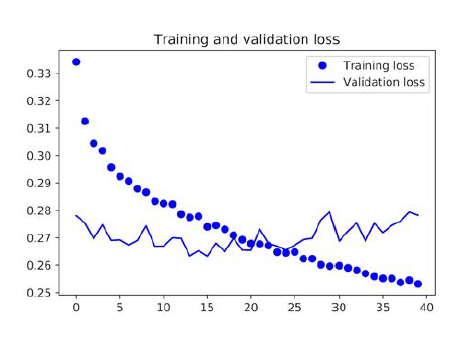

- We can see that the added layer does improve the results a bit, though not significantly. 

- We can draw two conclusions:
 - Because we’re still not overfitting too badly, we could safely increase the size of our layers in a quest for validation-loss improvement. This has a non-negligible computational cost, though.

 - Adding a layer didn’t help by a significant factor, so we may be seeing diminishing returns from increasing network capacity at this point.

### **Using bidirectional RNNs**

- A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. 

- It’s frequently used in natural-language processing— we could call it the Swiss Army knife of deep learning for natural-language processing.

- RNNs are notably order dependent, or time dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. 

- This is precisely the reason they perform well on problems where order is meaningful, such as the temperature-forecasting problem. 

- **A bidirectional RNN exploits the order sensitivity of RNNs**: it consists of using two regular RNNs, such as the GRU and LSTM layers.

- we’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations.

- By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

- Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. 

- At least, it’s a decision we made no attempt to question so far. Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance (newer timesteps first)? 

- Let’s try this in practice and see what happens. All we need to
do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets).

- Training the same one-GRU-layer network that we used in the first experiment in this section..

- We get the results shown below:

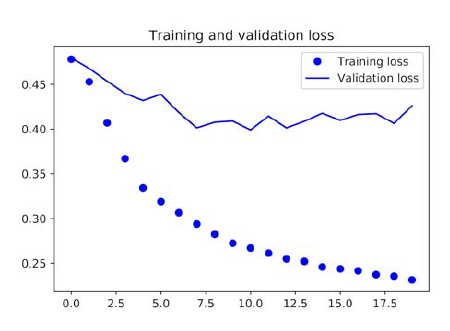

- The reversed-order GRU strongly underperforms even the common-sense baseline,
indicating that in this case, chronological processing is important to the success of your approach. 

- This makes perfect sense: the underlying GRU layer will typically be better at
remembering the recent past than the distant past, and naturally the more recent
weather data points are more predictive than older data points for the problem (that’s what makes the common-sense baseline fairly strong). 

- Thus the chronological version of the layer is bound to outperform the reversed-order version. 

- Importantly, this isn’t true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence isn’t usually dependent on its position in the sentence.

In [ ]:
# Training and evaluating an LSTM using reversed sequences

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
from keras.utils import pad_sequences

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(
num_words=max_features)

x_train = [x[::-1] for x in x_train]  # Reverses sequences
x_test = [x[::-1] for x in x_test]    # # Reverses sequences

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

- We get performance nearly identical to that of the chronological-order LSTM.

- Remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming the hypothesis that, **although word order does matter in understanding language, which order we use isn’t crucial**.

- **Importantly, an RNN trained on reversed sequences will learn different representations than one trained on the original sequences, much as we would have different mental models if time flowed backward in the real world—if we lived a life where we died on our first day and were born on our last day**. 

- In machine learning, **representations that are different yet useful are always worth exploiting, and the more they differ, the better**: they offer a new angle from which to look at our data, capturing aspects of the data that were missed by other approaches, and thus they can help boost performance on a
task. 

- This is the intuition behind ensembling.

- **A bidirectional RNN exploits this idea to improve on the performance of chronologicalorder RNNs**. 

- **It looks at its input sequence both ways see figure below, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone**.

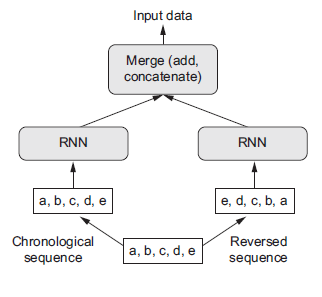

- To instantiate a bidirectional RNN in Keras, we use the **Bidirectional layer**, which takes as its first argument a recurrent layer instance. 

- **Bidirectional creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order**. 

- Let’s try it on the IMDB sentiment-analysis task.

In [ ]:
# Training and evaluating a bidirectional LSTM

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

- It performs slightly better than the regular LSTM we tried in the previous section, achieving over 89% validation accuracy. 

- It also seems to overfit more quickly, which is unsurprising because a bidirectional layer has twice as many parameters as a chronological
LSTM. 

- With some regularization, the bidirectional approach would likely be a
strong performer on this task.

- Now let’s try the same approach on the temperature-prediction task.

In [ ]:
# Training a bidirectional GRU

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

- This performs about as well as the regular GRU layer. 

- It’s easy to understand why: all the predictive capacity must come from the chronological half of the network, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case).

### **Going even further**

- There are many other things we could try, in order to improve performance on the temperature-forecasting problem:

 - Adjust the number of units in each recurrent layer in the stacked setup. The
current choices are largely arbitrary and thus probably suboptimal.

 - Adjust the learning rate used by the RMSprop optimizer.

 - Try using LSTM layers instead of GRU layers.

 - Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even a stack of Dense layers.

 - Don’t forget to eventually run the best-performing models (in terms of validation MAE) on the test set! Otherwise, we’ll develop architectures that are overfitting to the validation set.

- As always, **deep learning is more an art than a science**. 

- We can provide guidelines that suggest what is likely to work or not work on a given problem, but, ultimately, every problem is unique; we’ll have to evaluate different strategies empirically. 

- There is currently no theory that will tell us in advance precisely what you should do to optimally solve a problem. we must iterate.

### **Wrapping up**

- Here’s what you should take away from this section:

 - As we first learned, when approaching a new problem, it’s good to
first establish common-sense baselines for our metric of choice. 

 - If we don’t have a baseline to beat, we can’t tell whether we’re making real progress.

 - Try simple models before expensive ones, to justify the additional expense.

 - Sometimes a simple model will turn out to be our best option.

 - When we have data where temporal ordering matters, recurrent networks are
a great fit and easily outperform models that first flatten the temporal data.

 - To use dropout with recurrent networks, we should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all we have to do is use the dropout and recurrent_dropout arguments
of recurrent layers.

 - Stacked RNNs provide more representational power than a single RNN layer.

 - They’re also much more expensive and thus not always worth it. 
 
  - Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.

 - Bidirectional RNNs, which look at a sequence both ways, are useful on naturallanguage processing problems. But they aren’t strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

#### **NOTE**

-  There are two important concepts we won’t cover in detail here: **recurrent
attention and sequence masking**. 

- Both tend to be especially relevant for **natural-language processing**, and they aren’t particularly applicable to the temperature-forecasting problem.